### This is a Pytorch version of the work, for easier time working with ViT

# Step 1: Load and Preprocess the Dataset

### Load the GasVid dataset
### Preprocess the data
### Split the dataset into training and test sets

In [3]:
%%capture
%pip install --upgrade pip
%pip install -r ../requirements.txt

In [ ]:
# if apple and want MPS acceleration do this
# %%capture
# %pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

In [1]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor, ViTConfig
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm.notebook import tqdm

from sklearn.metrics import RocCurveDisplay, roc_curve, ConfusionMatrixDisplay, confusion_matrix

from sklearn.mixture import GaussianMixture


2023-10-11 23:53:42.621286: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-11 23:53:42.621317: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-11 23:53:42.621336: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-11 23:53:42.625798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Helper Functions

def calc_median(frames):
    median_frame = np.median(frames, axis=0).astype(dtype=np.uint8)
    return median_frame

def doMovingAverageBGS(image, prev_frames):
    median_img = calc_median(prev_frames)
    image = cv2.absdiff(image, median_img)
    return image

def calc_avg(frames):
  average_frame = np.mean(frames).astype(dtype=np.uint8)
  return average_frame

# Try Fixed background substraction
def doFixedBGS(image, init_frames):
  init_img = calc_avg(init_frames)
  image = cv2.absdiff(image, init_img)
  return image

# Try Mixture of Gaussian-Based (MOG) background substraction
def doMOGBGS(image, all_frames):
  gmm = GaussianMixture(n_components = 2)
  gmm_background = np.zeros(shape=(all_frames.shape[1:]))
  for i in range(all_frames.shape[1]):
      for j in range(all_frames.shape[2]):
          for k in range(all_frames.shape[3]):
              X = all_frames[:, i, j, k]
              X = X.reshape(X.shape[0], 1)
              gmm.fit(X)
              means = gmm.means_
              covars = gmm.covariances_
              weights = gmm.weights_
              idx = np.argmax(weights)
              gmm_background[i][j][k] = int(means[idx])
  image = cv2.absdiff(image, gmm_background)
  return image

In [3]:
def extractImages(pathIn, pathOut, leakRange, nonleakRange, currCountLeak, currCountNonLeak):

  '''
  Input:
    String: pathIn should be the path of the video
    String: pathOut should be the path of the folder where data is being stored for testing or training
    Tuple: range of leak frames from video
    Tuple: range of nonleak frames from video

  Output:
    creates two subfolders in pathOut called Leaks and Nonleaks
      Leaks folder contains the frames where there are leaks
      Nonleaks folder contains the frames where there are noleaks
  '''

  leakPath = os.path.join(pathOut, "Leak")
  nonleakPath = os.path.join(pathOut, "Nonleaks")

  os.makedirs(leakPath, exist_ok=True)
  os.makedirs(nonleakPath, exist_ok=True)

  def helper(pathIn, pathOut, range, isLeak, currCountLeak, currCountNonLeak):
    '''
    Might need to clean this up, but this was extracted from the original extractImages from the previous implementation

    '''
    #setting up moving average list
    prev_imgs = []
    prev_limit = 210 #210 in paper

    start = range[0] * 1000 # converting seconds to milliseconds
    end = range[1] * 1000
    cap = cv2.VideoCapture(pathIn)
    cap.set(cv2.CAP_PROP_POS_MSEC, start)
    success = True

    if cap.isOpened():
      while success and start < end:
          success, image = cap.read()
          if success:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            start = cap.get(cv2.CAP_PROP_POS_MSEC)
            prev_imgs.append(image)
            if len(prev_imgs) > prev_limit:
                prev_imgs.pop(0)

            processed_img = doMovingAverageBGS(image, prev_imgs) #to generalize might need to make this function as a parameter

            if isLeak:
                cv2.imwrite(os.path.join(pathOut, "leak.frame%d.jpg" % currCountLeak), processed_img)     # save frame as JPEG file
                currCountLeak += 1
            else:
                cv2.imwrite(os.path.join(pathOut, "nonleak.frame%d.jpg" % currCountNonLeak), processed_img)
                currCountNonLeak += 1
          else:
            break
      cap.release()
    cv2.destroyAllWindows()
    if isLeak:
       return currCountLeak
    else:
       return currCountNonLeak
  # call helper for both nonLeak and leak and get updated counts
  updated_currCountNonLeak = helper(pathIn, nonleakPath, nonleakRange, isLeak=False, currCountLeak=currCountLeak, currCountNonLeak=currCountNonLeak)
  updated_currCountLeak = helper(pathIn, leakPath, leakRange, isLeak=True,currCountLeak=currCountLeak, currCountNonLeak=currCountNonLeak)

  return updated_currCountNonLeak, updated_currCountLeak

### Setting up Directories

In [4]:
# get generic path to directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

# get all raw video data directories
data_dir = os.path.join(dir_path, 'data')

train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

frame_data_dir = os.path.join(dir_path, 'frame_data_movingAvg')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')


### Setting Up Ranges for Each Video In GasVid (Excluding 18.6m and 8.8m)

In [5]:
raw_data = np.loadtxt(os.path.join(dir_path, 'GasVid_Ranges_Seconds.csv'), skiprows=1, delimiter=',', dtype=int)

ranges = list(zip(raw_data[:, 0], raw_data[:, 1:3], raw_data[:, 3:5])) #need to upload new ranges
ranges = {ranges[i][0] : (ranges[i][1], ranges[i][2]) for i in range(len(ranges))}
len(ranges)

25

In [6]:
import re
def read_frames_from_dir(dir_path, output_path, max_vids=None):
    cur_count = 1
    currNonLeakCount = 0
    currLeakCount = 0

    for file in os.listdir(dir_path):
        if max_vids and cur_count > max_vids:
            break
        vid_path = os.path.join(dir_path, file)
        vid_id = int(re.findall("_(\d{4}).mp4",os.path.basename(vid_path))[0])
        # vid_id = int(os.path.basename(vid_path)[4:8])
        if vid_id not in ranges.keys():
            continue

        nonleak_start = ranges[vid_id][0][0]
        nonleak_end = ranges[vid_id][0][1]
        leak_start = ranges[vid_id][1][0]
        leak_end = ranges[vid_id][1][1]

        currNonLeakCount, currLeakCount = extractImages(vid_path, output_path, (leak_start, leak_end), (nonleak_start, nonleak_end), currLeakCount, currNonLeakCount)
        print("Video", vid_id)
        print("Current NonLeak Count", currNonLeakCount)
        print("Current Leak Count", currLeakCount)

        print('Done with', cur_count, "video(s)")
        cur_count += 1
    return currNonLeakCount, currLeakCount

### Reading Frames from Data Directory and Setting Them in Frame Data Directory

In [8]:
image_dim = (240, 320)
vid_count = None # Smaller on local computer to limit computer resources #max =>15

test_count = None #Smaller on local computer to limit computer resources #max =>10
total_train_NonLeak, total_train_Leak = read_frames_from_dir(train_data_dir, frame_train_data_dir, vid_count)
print("Done with Training Data")
total_test_NonLeak, total_test_Leak = read_frames_from_dir(test_data_dir, frame_test_data_dir, test_count)
print("Done with Testing Data")

Video 2570
Current NonLeak Count 2386
Current Leak Count 18475
Done with 1 video(s)
Video 2564
Current NonLeak Count 4774
Current Leak Count 36946
Done with 2 video(s)
Video 2559
Current NonLeak Count 7160
Current Leak Count 55410
Done with 3 video(s)
Video 2567
Current NonLeak Count 9545
Current Leak Count 73896
Done with 4 video(s)
Done with Training Data
Video 1469
Current NonLeak Count 2384
Current Leak Count 18485
Done with 1 video(s)
Video 1468
Current NonLeak Count 4771
Current Leak Count 36972
Done with 2 video(s)
Done with Testing Data


In [7]:
print("Total NonLeak Count", total_train_NonLeak + total_test_NonLeak)
print("Total Leak Count", total_train_Leak + total_test_Leak)

NameError: name 'total_train_NonLeak' is not defined

# Step 2: Create Dataset for Ingesting Image Frames

In [7]:
class MultiClassVideoFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None, processor=None):
        self.root_dir = root_dir
        self.transform = transform
        self.processor = processor
        self.classes = os.listdir(root_dir)  # Get class names from subdirectories

        self.frames = []
        self.labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            frame_list = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.jpg', '.png', '.jpeg'))]
            self.frames.extend(frame_list)
            self.labels.extend([class_idx] * len(frame_list))

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame_path = self.frames[idx]
        image = cv2.imread(frame_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        if self.transform:
            image = self.transform(image)
        
        if self.processor:
            image = self.processor.preprocess(image, return_tensors="pt")

        label = self.labels[idx]

        return image, label

In [8]:
image_processor = ViTImageProcessor(
    "google/vit-base-patch16-224",
    do_normalize=True,
    max_size=384,
    pad_to_max_size=True
)

In [9]:
# define some transforms
transform = transforms.Compose([
])

In [10]:
full_train_dataset = MultiClassVideoFrameDataset(root_dir=frame_train_data_dir, transform=transform, processor=image_processor)
test_dataset = MultiClassVideoFrameDataset(root_dir=frame_test_data_dir, transform=transform, processor=image_processor)

# Define the percentage of data to use for validation
validation_split = 0.2  # Adjust this as needed

# Calculate the number of samples for the validation set
num_samples = len(full_train_dataset)
num_val_samples = int(validation_split * num_samples)
num_train_samples = num_samples - num_val_samples

# Create a list of indices for the full dataset
indices = list(range(num_samples))

# Use random sampling to split the indices into train and validation indices
val_indices = torch.randperm(num_samples)[:num_val_samples]
train_indices = list(set(indices) - set(val_indices))

# Create Subset objects for train and validation
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_train_dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
len(full_train_dataset) + len(test_dataset)

584636

# Step 3: Build the GasViT Architecture

### Define the GasNet architecture (GasNet-2 as mentioned in the paper)
### Implement the model using TensorFlow/Keras

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
# model.to(device)

device(type='cuda')

In [13]:
configs = ViTConfig(
    hidden_dropout_prob=0.5,
    attention_probs_dropout_prob=0.2
)

In [14]:
# Initialize the ViT feature extractor and model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', config=configs, ignore_mismatched_sizes=True)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [15]:
# Change classifier layer to have num classes consistent with dataset
model.classifier.out_features = len(full_train_dataset.classes)
model.classifier

Linear(in_features=768, out_features=2, bias=True)

In [16]:
train_dataloader.dataset.dataset.classes

['Leak', 'Nonleaks']

In [17]:
def train(model, weight=None, num_epochs=10):
    criterion = nn.CrossEntropyLoss(weight=weight) # extendable for multiclass classification as well
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # can try out lr scheduler later if needed
    # can also try out warmup ratio

    for epoch in range(num_epochs):
        model.train()
        for batch_images, batch_labels in tqdm(train_dataloader):
            batch_image_pixels, batch_labels = batch_images.pixel_values.squeeze(1).to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_image_pixels).logits
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

        model.eval()
        accuracy = 0
        total_samples = 0

        with torch.no_grad():
            for batch_images, batch_labels in tqdm(val_dataloader, leave=False):
                batch_image_pixels, batch_labels = batch_images.pixel_values.squeeze(1).to(device), batch_labels.to(device)
                outputs = model(batch_image_pixels).logits
                _, predicted = torch.max(outputs, 1)
                accuracy += (predicted == batch_labels).sum().item()
                total_samples += batch_labels.size(0)

        validation_accuracy = accuracy / total_samples
        print(f"Validation Accuracy: {validation_accuracy:.4f}")


### Adjust classweights to account for class imbalance

In [22]:
# Adjust Class weights here
class_weight = torch.tensor([1, 8]).float().to(device)

In [23]:
train(model, class_weight, 6)

  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 1/6, Loss: 0.5135


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.9210


  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 2/6, Loss: 0.2012


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.9443


  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 3/6, Loss: 0.1108


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.9442


  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 4/6, Loss: 0.3122


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.9147


  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 5/6, Loss: 0.0904


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.9465


  0%|          | 0/10869 [00:00<?, ?it/s]

Epoch 6/6, Loss: 0.1218


  0%|          | 0/2174 [00:00<?, ?it/s]

Validation Accuracy: 0.9504


In [24]:
# Specify the file path for saving the model
model_path = 'vit_model_dropout_weighted.pth'

# Save the model's state_dict to the specified file
torch.save(model.state_dict(), model_path)

In [25]:
model_path = 'vit_model_dropout_weighted.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Step 4: Evaluate the model on the Test Dataset

### Generate evaluation metrics and plots such as confusion matrix and ROC curves, F1 score, etc.

We are primarily concerned with high false positive rate due to the extreme class imbalance

In [26]:
def predict(model):
    model.eval()
    accuracy = 0
    total_samples = 0
    predictions = []  # List to store the predictions
    truth_labels = []  # List to store the truth labels

    with torch.no_grad():
        for batch_images, batch_labels in tqdm(test_dataloader, leave=False):
            batch_image_pixels, batch_labels = batch_images.pixel_values.squeeze(1).to(device), batch_labels.to(device)
            outputs = model(batch_image_pixels).logits
            _, predicted = torch.max(outputs, 1)
            accuracy += (predicted == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

            predictions.extend(predicted.cpu().numpy())
            truth_labels.extend(batch_labels.cpu().numpy())

    validation_accuracy = accuracy / total_samples
    print(f"Test Accuracy: {validation_accuracy:.4f}")
    return predictions, truth_labels

In [27]:
predictions, truth_labels = predict(model)
predictions, truth_labels = np.array(predictions), np.array(truth_labels)

  0%|          | 0/7402 [00:00<?, ?it/s]

Test Accuracy: 0.8605


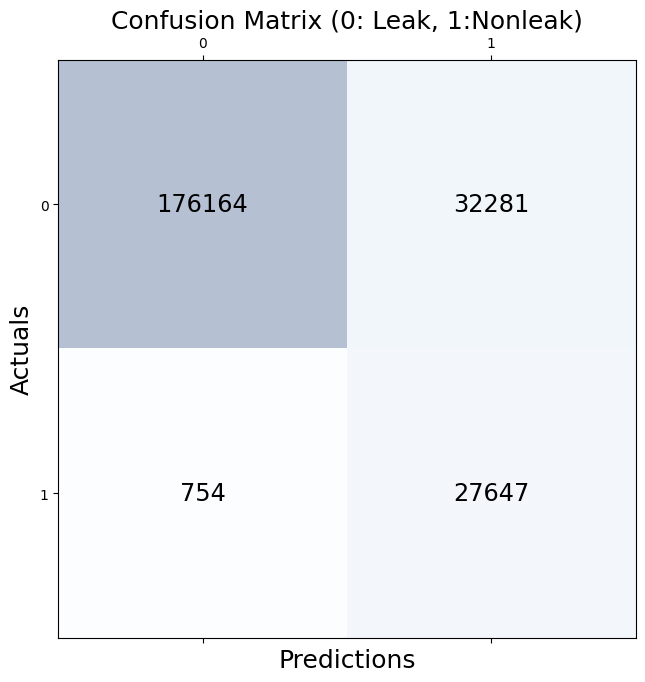

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#source: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/

conf_matrix = confusion_matrix(y_true=truth_labels.astype(int), y_pred=predictions)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title(f'Confusion Matrix (0: Leak, 1:Nonleak)', fontsize=18)
plt.show()

In [29]:
from sklearn.metrics import accuracy_score,f1_score
accuracy = accuracy_score(truth_labels, predictions)

In [30]:
accuracy

0.8605211825405538

In [31]:
f1 = f1_score(truth_labels, predictions)
f1

0.6260005207802648

In [32]:
conf_matrix = confusion_matrix(truth_labels, predictions)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

In [33]:
for label, acc in zip(['Leak', 'Nonleak'], per_class_accuracy)
    print(f"Class '{label}' Accuracy: {acc:.4f}")

Class 'Leak' Accuracy: 0.8451
Class 'Nonleak' Accuracy: 0.9735
